# Machine Learning in Python - Project 1
---
- Annette Bell (s2089966)
- Billie Harris (s2264941)
- James Grant (s2087525)
- Adrián Garnier Artiñano (s2246745)

## 0. Setup

In [ ]:
# Add any additional libraries or submodules below
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

from scipy import stats

# Typing imports
from typing import List
# Regression Tree Visualization imports
from six import StringIO
from IPython.display import Image  
import pydotplus

In [ ]:
# Load data
d = pd.read_csv("the_office.csv")
d_extended = pd.read_csv("the_office_Extended_.csv")

## 1. Introduction

Our primary objective is to advise NBC Universal on what they should do to produce the highest rated reunion episode possible. To predict the success of the reunion episode, we use IMDb ratings as the outcome of interest, as this is what the creators are keen to maximize. 

We assume that this episode will follow a similar layout as previous episodes; actors will be playing their assigned characters in a scripted episode. Additionally, we assume that there are no unavailability constraints for actors, writers, and directors.

In order to understand what makes some of The Office episodes more popular than others, we examine the initial data set provided which includes features such as season, episode, director, writer, IMDb rating, and main characters among others. While this dataset provides us with useful insight into each episode, for a more comprehensive understanding, we utilize an additional dataset (Prabhavalkar, 2020) that has information regarding the following:
* ```GuestStars``` - binary column indicating whether at least one guest star was present in the episode or not,
* ```Duration``` - the length of the episode in minutes,
* ```Viewership``` - the number of viewers in the USA in millions,
* ```episode_name``` - the title of the episode. 

*We altered a select number of episode titles in the additional dataset in order to match and merge with the original dataset.*

Our additional data should improve the predictive power of our model by introducing new features that allow the creators to consider more ways to produce a highly rated reunion episode.   

With a more compehensive dataset, we then consider a number of different models that estimate the best features to include in the highest rated reunion episode possible, before settling on a <ins>decission tree regressor model</ins>. This method has a relatively high accuracy and produces visual results that make it clear which features are the best and worst, regardless of an individual's background in coding or Machine Learning. 

<br>

**From our model analysis, we believe that NBC Universal should:**
1. Include main characters Michael, Ryan, Dwight, and Jim in the reunion epsiode. 
2. Ensure that the script contains at least 2,841 words and 301 lines.

These recommendations are a result of high R<sup>2</sup> value, indicating that the model has strong predictive power, as well as the regression tree itself which contains high estimated IMDb scores with minimal error. 

<br>

---

To better understand how we arrived at our final recommendations, we will first, outline our exploratory data analysis and feature engineering. Next, we will discuss our model creation and tuning process. Finally, we will discuss the results of the model and clearly restate our recommendations. 

## 2. Exploratory Data Analysis and Feature Engineering

Our goal for this project is to try and find features from previous episodes of The Office that the creators should consider when trying to create the highest rated reunion episode possible. Before we attempt to create a model, we shall explore the data set to see if there are any obvious good or bad features from previous episodes that can be observed at this stage. 

One primary issue with this initial dataset is that in some instances, directors' names are spelt correctly, and on other occasions they are not. Additionally, the way in which directors, writers, and characters are involved with each episode is currently displayed in a way that makes it difficult to observe patterns between their involvement in episodes and the IMDb ratings of said episodes. 

Although we could complete some initial analysis of the original dataset in its current format, it seems more logical to modify the dataset first, as we know that a particular writer, director, or character may single handedly influence the success of an episode. For this reason, we shall separate each of these individuals into their own binary columns of whether they were involved in each episode or not. 

<br>

---

First, we merge our original dataset with the additional dataset from Kaggle by episode name. 

In [ ]:
#Pull desired data from the additional dataframe
d_extra = d_extended.drop(["Votes","Date","Director","Writers", "imdb_rating", 
                           "About","season"], axis=1)

#change "GuestStars" to binary: 1= at least 1 guest star in episode, 0 otherwise
d_extra["GuestStars"] = np.where(d_extra["GuestStars"].isnull(), 0, 1) 

#Merge original dataset and additional dataset
d_complete = pd.merge(d, d_extra, on='episode_name', how='outer')

Secondly, we correct the spelling mistakes using a dictionary comprised of keys containing incorrect spellings that need to be replaced, and values with the corrections.

In [ ]:
corrections ={"Charles McDougal": "Charles McDougall",
              "Claire Scanlong": "Claire Scanlon",
              "Greg Daneils": "Greg Daniels",
              "Ken Wittingham": "Ken Whittingham",
              "Paul Lieerstein": "Paul Lieberstein",}

#Use the dictionary above to replace incorrect spellings with correct versions. 
d_complete = d_complete.replace({"director": corrections})

#Split directors, writers, & characters into separate lists for one hot encoding.
d_complete["director"] = d_complete["director"].str.split(";")
d_complete["writer"] = d_complete["writer"].str.split(";")
d_complete["main_chars"] = d_complete["main_chars"].str.split(";")

Finally, we implement one hot encoding for the directors, writers, and characters to create binary features to indicate which episodes these individuals were involved in. 

In [ ]:
# Create one hot encoding for director, main characters, and writers
mlb = MultiLabelBinarizer()

main_chars_ohe = pd.DataFrame(mlb.fit_transform(d_complete.main_chars),
                   columns=mlb.classes_)
director_ohe = pd.DataFrame(mlb.fit_transform(d_complete.director),
                   columns=mlb.classes_)
writer_ohe = pd.DataFrame(mlb.fit_transform(d_complete.writer),
                   columns=mlb.classes_)

###<ins>Data Analysis</ins>

To better understand the data, we begin by analysing the relationship between season and IMDb rating (*Figure 1*) as well as season and viewership (*Figure 2*).


Viewership and IMDb rating have a relatively high correlation of 0.49.



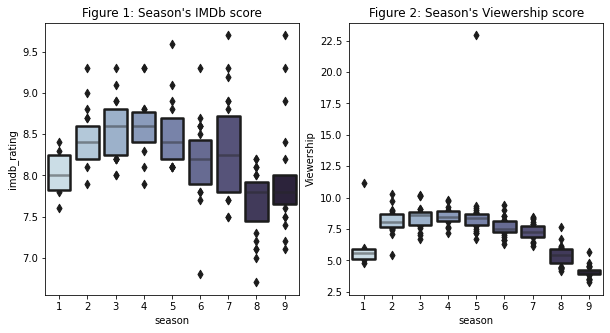

In [ ]:
#Plot figures one and two
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.boxenplot(x="season", y="imdb_rating", data=d_complete, 
              linewidth=2.5, palette="ch:s=.25,rot=-.25",
              ax=ax1).set(title="Figure 1: Season's IMDb score")
sns.boxenplot(x="season", y="Viewership", data=d_complete, 
              linewidth=2.5, palette="ch:s=.25,rot=-.25", 
              ax=ax2).set(title="Figure 2: Season's Viewership score")
fig.show()

print("Viewership and IMDb rating have a relatively high correlation of ", 
      round(d_complete[["imdb_rating","Viewership"]].corr()["Viewership"][0],2),
      ".\n", sep='')

As shown in *Figure 1*, we notice that the IMDb ratings show a general increase between the first and fourth seasons. Between seasons 5 and 7, the average IMDb ratings show a slight downward trend. But, we also observe for these seasons (especially seasons 6 and 7), that the variance of scores increases drastically compared to the first four seasons; with some of the highest as well as lowest rated episodes coming from these seasons. 

In comparison, the average IMDb rating for seasons 8 and 9 are much lower than the average ratings for the first 7 seasons. In fact, this figure shows that the highest score seen in season 8 is slightly lower than the mean score for season 7. 

After better understanding how IMDb ratings vary across the seasons, if we now analyse *Figure 2*, we obsevre a similar trend in the viewership for each season. Similar to IMDb rating, viewership is out of the control of NBC Universal, as such we believe it doesn't meet the criteria to be a feature in our model. This is further supported by our findings which show that the features ```IMDb rating``` (our independent variable) and ```viewership``` are highly correlated. As such, including viewership in our model could artificially inflate the model's accuracy. ***For these reasons, during the pre-processing phase, we remove ```viewership```***.

Another feature that must be removed is ```season``` as NBC Universal cannot retroactively add the reunion episode to a previous season. Comparably, an episode's name and number do not have an impact on IMDb score and therefore should not be considered as features. We acknowledge that episode name could be analysed using sentiment analysis; however, we believe this is beyond the scope of the project and would have marginal impact on the model. ***As such, we remove ```season```, ```episode```, and ```episode_name``` from the data set***.

Finally, we acknowledge that ```total_votes``` is not a feature that NBC Universal can directly control, as votes is a continuous variable which represents the total number of critics who rated the episode on IMDb. Consequently, it could be argued ```total_votes``` should be dropped as a feature at this stage. However, we acknowledge that the higher the number of votes, the higher the chance of a pile on effect occuring (which is when individuals uphold the views and ratings that already exist (Merriam-Webster, 2022)). Hence, the ratings for episodes with a higher number of votes may not accurately reflect the public's true opinion on the episode. ***Therefore, we shall remove ```total_votes``` in the modelling stage after this feature has been used to remove any outliers from the dataset.***

<br>

---

Qualitatively, we know that the character Michael leaves the show towards the end of season 7. We theorize that Michael's presence in an episode is highly correlated with that episode's IMDb rating. As such, we now explore the relationship between IMDb rating and each of the main characters.


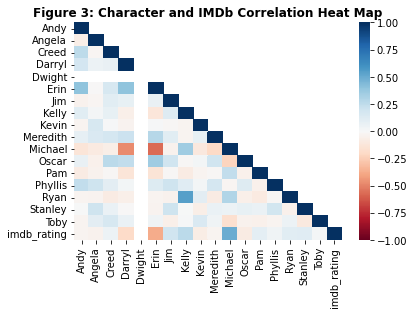

In [ ]:
# Characters exploration and correlation with imdb_rating.
char_dataset = main_chars_ohe.copy()
char_dataset['imdb_rating'] = d_complete.loc[:,['imdb_rating']]

#Create correlation data
corr = char_dataset.corr()
corr_half = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

#Plot correlation of characters as well as IMDb rating
ax=plt.axes()
sns.heatmap(corr_half, xticklabels=corr.columns, yticklabels=corr.columns,
        cmap = 'RdBu', center = 0.0, vmin=-1, vmax=1)

ax.set_title("Figure 3: Character and IMDb Correlation Heat Map", 
             fontweight="bold")
plt.show()

The bottom row of *Figure 3* above indicates the correlation between a character's appearance in an episode and the IMDb rating of said episode. The remainder of the heatmap shows the correlation between the main characters' appearance in episodes. For example, Erin and Andy appear in many episodes together and hence their episode appearances have a high correlation with one another. *Note here that blue indicates a positive correlation and red indicates a negative correlation and the stronger the intensity of the colour, the stronger the correlation.*

Subsequently, it is clear to see that Michael's appearance in episodes has a strong positive correlation with IMDb scores. This supports our theory that his departure in season 7 is likely one of the core reasons for the drop in average IMDb scores in all seasons thereafter.

Additionally, we see that Erin and Darryl's appearances both have a negative correlation with IMDb scores. However, both of their appearances are negatively correlated with Michael's appearanaces in the show. This highlights that both of these characters become bigger characters in the show in later seasons, after Michael's departure when ratings were already low. As a result of this correlation, we cannot conlcude at this stage that these characters should not be included in the reunion episode, rather that we need to carry out further feature analysis. 

Another important factor to note here is that Dwight appears in all 186 episodes of the show. Although Dwight might be an important character in the show, including him as a feature does not impact the predictive power of the model and would act as noise. ***We exclude ```Dwight``` from the model***. Please note, this does not mean that Dwight should be excluded from the reunion episode. Instead, the creators would need a more quantative method to ascertain if his character should be included in the reunion episode or not, as we cannot do this qualitively using the data from the previous episodes. 

<br>

---

We now examine more closely each character's appearance in an episode relationship to IMDb score.

Text(0.5, 0.9, "Figure 4: Main Character's IMDb Rating Based on TV Appearance")

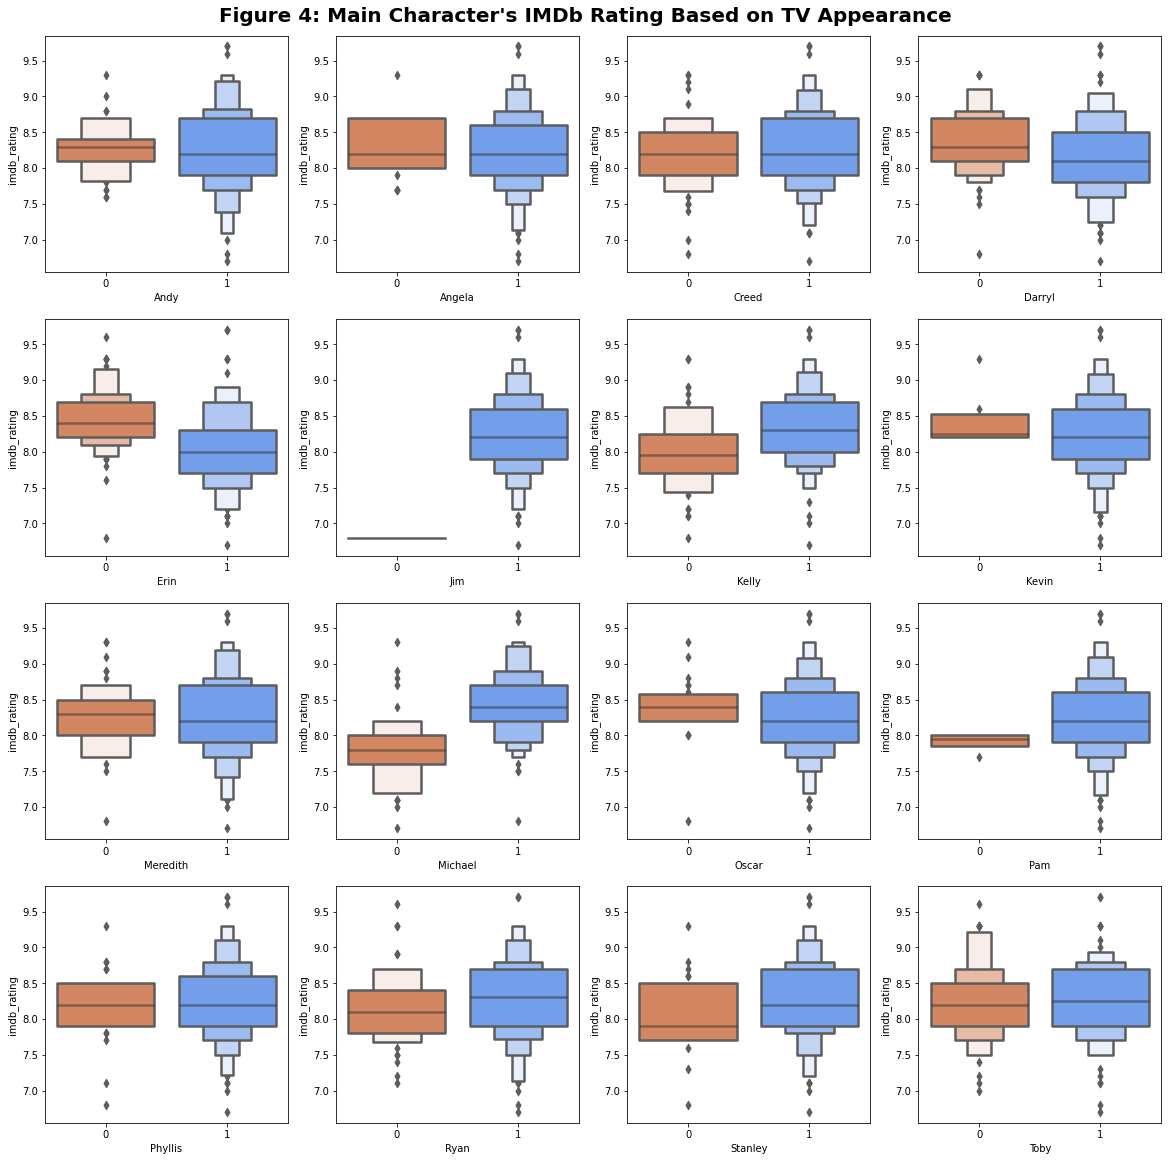

In [ ]:
#Format character names 
character_bp = main_chars_ohe.copy()
character_bp['imdb_rating'] = d_complete.loc[:,'imdb_rating']

#Examine characters' relationship to IMDb score for presence in each episode
#Note: we exclude Dwight from boxplot as he will not be included as a feature
char = list((main_chars_ohe.columns).drop("Dwight"))
fig, ax = plt.subplots(4,4, figsize=(20,20))
characters_to_plot = char[:4], char[4:8], char[8:12], char[12:]
for i, row in enumerate(characters_to_plot): #plot
  for j, character in enumerate(row):
    sns.boxenplot(x= character, y= "imdb_rating", data=character_bp, 
                  linewidth=2.5, palette=["#E67F4F","#6099FC"], 
                  showfliers=True, ax=ax[i,j])
fig.show()
plt.suptitle("Figure 4: Main Character's IMDb Rating Based on TV Appearance", 
             x=0.5, y=.9, fontsize=20, fontweight= "bold")


Based on *Figure 4*, we notice that some characters' presence in an episode have an impact on an episode's IMDb score.

<ins>Characters with Little Predictive Power:</ins> Similar to Dwight, Jim appears in the majority of episodes, therefore the feature ```Jim``` has little predictive power. Furthermore, we take the single episode Jim does not appear in as an outlier due to its significantly low IMDb rating. ***From this information, we remove ```Jim``` from the data during the pre-processing phase.***

<ins>Characters with Negative Correlation on IMDb Rating:</ins> Darryl, Erin,  and Oscar have lower mean IMDb ratings for episodes they are in compared to episodes they are not in. This suggests a negative correlation between episode IMDb ratings and their appearance in episodes. 

<ins>Characters with Positive Correlation on IMDb Rating:</ins> Kelly, Michael, and Stanley show positive correlation between episode presence and IMDb rating. Additionally, it is important to highlight that Michael has the biggest impact on IMDb rating out of all main characters on the show. In spite of this, we cannot immediately conclude that including all three of the above characters will lead to a high IMDb score as this correlation could simply be happenstance.

<br>

---

After examining each of the characters, we explore the directors and writers relationship to the show and its IMDb score. To reduce dimensionality of the features, ***we remove all individuals who only wrote or directed one episode***. This is because their involvement in an episode has little to no predictive power due to their significantly low sample size. 

Additionally, to provide clarity, we append ```_d``` and ```_w``` to each person based on their type of involvement as some individuals both wrote and directed for the show.

In [ ]:
#Determine which individuals directed or wrote for only one show
remove_directors = list(director_ohe.columns[(director_ohe.sum()==1)])
remove_writers = list(writer_ohe.columns[(writer_ohe.sum()==1)])

#Appen _d and _w to indicate their job type
remove_directors = [element + "_d" for element in remove_directors]
remove_writers = [element + "_w" for element in remove_writers]

print("There are", len(remove_directors),
      "individuals who only directed 1 episode and", len(remove_writers),
      "individuals who only wrote for 1 episode.")

There are 22 individuals who only directed 1 episode and 6 individuals who only wrote for 1 episode.


***These 28 writers and/or directors will be removed during the pre-processing phase.***

<br>

---

In addition to selecting which individuals to involve in the reunion episode, we also know that NBC Universal can choose what date to air the episode. For this reason, we believe it is important to determine if day of the week and month in which the reunion episode is aired will have any correlation to IMDb score.

In [ ]:
# Date exploration
air_date = d.loc[:,['air_date','imdb_rating']]

air_date['day_of_week'] = pd.to_datetime(air_date.air_date).dt.dayofweek
air_date['month'] = pd.to_datetime(air_date.air_date).dt.month

pd.DataFrame(air_date.corr()["imdb_rating"][1:])

,imdb_rating
day_of_week,0.040266
month,-0.000854


The above table indicates that neither day of the week nor month are strongly correlated with IMDb rating. ***As a result, we exclude ```air_date``` from the dataset.*** 

*Note, we did not examine IMDb rating and year as NBC Universal cannot retroactively release a reunion episode.*

<br>

---

###<ins>Preprocessing</ins>

Based on our analysis, we modify the dataset that we shall run the model on:
1. Separate each of the directors, writers, and main characters into their own columns of the dataset, using one hot encoding, and add ```_d``` and ```_w``` to the directors and writers respectively. 
2. Remove the combined columns of director, writer, and character. 
3. Remove predetermined features: ```season```, ```episode```, ```episode_name```, ```air_date```, ```Viewership```, ```Dwight```, ```Jim```, and the 28 writers/directors.

In [ ]:
#Specify which indivduals are directors, writers,  and main characters
d_process = d_complete.join(director_ohe.add_suffix('_d'))
d_process = d_process.join(writer_ohe.add_suffix('_w'))
d_process = d_process.join(main_chars_ohe)
d_process = d_process.drop(['director', 'writer', 'main_chars'], axis=1)

# Removing unneeded features 
d_process = d_process.drop(remove_directors, axis=1)
d_process = d_process.drop(remove_writers, axis=1)
d_process = d_process.drop(['season', 'episode','episode_name','air_date', 'Viewership','Dwight','Jim'], axis=1)

Now that we have pre-processed the data, we begin fitting and tuning our model.

<br> 

---

## 3. Model Fitting and Tuning

Before settling on a regression tree, we considered a number of other models and compared their accuracy at predicting how to best make an episode with the highest IMDb rating. To begin, we implemented principal component analysis (PCA) and reduced the dimensionality to 3 with relatively high accuracy. However, PCA removes the clarity of which features actually contribute to the model and therefore would not help provide useful feedback to NBC Universal. 

Next, we attempted a polynomial regression where all feature combinations were tested to determine which combination led to the highest IMDb score. This method was eventually discarded due to it's large dimensionality and computational expense. 

We also considered implementing a categorical decision tree, where we categorized each of the episodes into bands from "Very Good" to "Very Bad", based on their IMDb ratings. However, as this model was trained to predict features of a "Very Good" episode, we ran into issues mapping our findings back to predicting the highest possible IMDb score of the reuninion episode. 

Instead, we decided to implement a regression tree, as we believed this model would similarily give us an accurate prediction that would be easily comprehensible, as the visual output allows all to see clearly which factors of previous episodes are indicative of high IMDb ratings. It is therefore this model that we utilize to determine the most important features to create the highest possible IMDb rating for the reunion episode. 

As previously stated in the pre-processing stage above, we only include features from the ```d_process``` dataset that have a substancial predictive power as well as features that are controllable by NBC Universal. 

The original dataset provides us with a list of characters that appear in each episode but we are unclear as to which characters share scenes and storylines together. For this reason, we do not add additional features that show which characters are in the same episodes. However, as the decision tree gives a clear indication as to which combination of characters leads to a high IMDb score, we conclude that adding these additional interaction features would be redundant. 

During the modeling process, we first fine tune the dataset for the model by removing outliers from ```imdb_rating``` and ```total_votes```. Next, we begin the process of tuning the model by first running the model without any parameters, then with arbitrary parameters, and finally with hyperparameters. This allows us to better understand the model and improve its' predictive power.  

<br>

---

First, we create a helper function entitled *remove_outliers* which takes three inputs:
1. A dataframe
2. A list of column names
3. Desired Standard Deviation.

In [ ]:
# Create helper function
def remove_outliers(df: pd.DataFrame, column_names: List[str], deviation: float = 3) -> pd.DataFrame:
    '''
    Remove the outliers given a list of columns.

    Parameters:
      df (pd.DataFrame): Dataframe that includes desired columns 
                         to potentially replace.
      column_names (List[str]): List of columns to remove outliers from.
      deviation (float)[default=3.0]: The standard deviation used to determine 
                                      if a data point is an outlier or not.

    Returns:
      result_df (pd.DataFrame): A new dataframe with the changes applied.
    '''

    # Raises an error if a column is not in the specified dataframe.
    for column in column_names:
      if column not in df.columns:
        raise ValueError(f"Column {column} does not exist in the dataframe.")
        return df 

    # Creates a copy of the original dataframe and removes outliers.    
    for column in column_names:
      result_df = df.loc[(np.abs(stats.zscore(df[column])) < deviation)].copy()
    return result_df

The function first ensures that the columns from the column list are in the dataframe. Next, the function removes outliers that are *x* number of standard deviations away from the mean. Finally, it returns a new dataframe that has the change. *Note: This function does not modify the original dataframe to ensure integrity of the original information.* 

The purpose of this function is to remove episodes that contain outlier values to prevent our results from being skewed. *Remove_outliers* will be used for the columns imdb_rating and total_votes. We will first remove outliers from the independent variable, ```imdb_rating```, as it is the most important aspect of our model. Then, as previously mentioned, we remove episodes based on outliers in ```total_votes``` to provide greater model accuracy. Finally, we drop ```total_votes``` as NBC Universal cannot control this when creating the reunion episode. 

In [ ]:
#Create Final Regression Dataset
d_regression = d_process.copy()
d_regression = remove_outliers(d_regression, ['imdb_rating'], deviation = 2.5)
d_regression = remove_outliers(d_regression, ['total_votes'])
d_regression.drop(['total_votes'], axis=1, inplace = True)

After finalising the regression dataset, we begin the modelling process by first running an 'unconstrained' model.

<br>

---

###<ins>The Unconstrained Model</ins>

In this context, we refer to an '*unconstrained model*' as one without parameters that specify features of the decision tree. For example, we do not set a maximum regression tree depth, nor do we set the minimum number of splits.

We stratify the data by bins based on a "five star rating" where the 1 bin is the worst rated episodes and 5 contains the best rated episodes. This is to ensure that both the testing and training data have a reasonable split of both highly and poorly rated episodes. When splitting the data, we implement a reasonable test size of 25% and chose a random value of 23 for the random state. 

In [ ]:
#Choose how to stratify dataframe 
bins_u = pd.cut(d_regression['imdb_rating'], 5)

#Specify independent and dependent data
X = d_regression.drop('imdb_rating',axis=1) # Independet variable
y = d_regression['imdb_rating'] # dependent variable

#Create Unconstrained training and testing set
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y, test_size=0.25, random_state=23, stratify = bins_u)

We then input the unconstrained training and testing data into our Decision Tree for Regression Pipeline. Due to the binary features created by one-hot encoding, we normalize the data within the Pipeline. The 'Normalizer' converts non-binary features (```n_lines```, ```n_directors``` , ```n_words``` , ```n_speak_char```, and ```Duration```) to values between 1 and 0 where 0 is the minimum value and 1 is the maximum value of that feature. This is to ensure that the datasets continuous and binary features are given equal importance by the model.

In [ ]:
#Build the pipeline and fit the unconstrained model without parameters set
regressor_pipeline = Pipeline([('Normalizer', MinMaxScaler()), ('DTR',DecisionTreeRegressor(random_state = 42))])
regressor_pipeline.fit(X_train_u, y_train_u)

#Print Results (to 5 significant figures for R^2)
print('R\u00b2 score:', f'{regressor_pipeline.score(X_test_u, y_test_u):.5}')
print('Number of nodes:', regressor_pipeline['DTR'].tree_.node_count)

R² score: 0.099931
Number of nodes: 209


Without tunning the model, we obtained an R<sup>2</sup> score of 0.0999 (3 significant figures). As the R<sup>2</sup> value indicates the level of variation in IMDb score that can be predicted from our dataframe, we would want our R<sup>2</sup> value to be closer to one. However, we see here that we have a very low R<sup>2</sup> value, which indicates that the current, unconstrained model is poor at predicting what elements should be included in a highly rated reunion episode. 

Additionally, the number of nodes considered is large, suggesting that the model is extremely granular. Instead, we would prefer a model that considers less nodes, as nodes that are split closer to the top of the tree indicate the most important features to consider, and any additional nodes would provide less meaningful information to the creators. 

We tune the model by adding arbitrary parameters.

<br>

---

###<ins>The Constrained Model</ins>

First, we specify parameters of the decision tree to include criterion, random seed, random state, maximum depth, and the minimum number of sample leaves.

Then, we implement the new parameters into the pipeline, fit the data, and print the results.




In [ ]:
#Specify features of the decision tree:
criterion_to_use = 'squared_error'
random_model_seed = 4
random_split_seed = 23
max_depth = 3
min_samples_leaf = 2

#Choose how to stratify dataframe 
bins_c = pd.qcut(d_regression['imdb_rating'], 5)

#Create the training and testing set for the constrained model
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.25, random_state = random_split_seed, stratify = bins_c)

#Build the pipeline and fit the constrained model with specified arbitrary values
regressor_pipeline_c = Pipeline([('MinMaxScaler', MinMaxScaler()), ('DTR',DecisionTreeRegressor(criterion = criterion_to_use, random_state = random_model_seed, max_depth = max_depth, min_samples_leaf = min_samples_leaf))])

regressor_pipeline_c.fit(X_train_c, y_train_c)

#Print Results 
print('\n \033[1m' + 'Constrained Regressor Tree' + '\033[0m')
print(f'\tSplit seed = {random_split_seed},\tModel seed = {random_model_seed},\tCriterion = {criterion_to_use}')
print('\tR\u00b2 score:', f'{regressor_pipeline_c.score(X_test_c, y_test_c):.5}')
print('\tNumber of nodes:', regressor_pipeline_c['DTR'].tree_.node_count)


 Constrained Regressor Tree
	Split seed = 23,	Model seed = 4,	Criterion = squared_error
	R² score: 0.51561
	Number of nodes: 13


Here, we see that the R<sup>2</sup> value has increased significantly, which suggests that by setting parameters of the model arbitrarily, we increase the predictive power of the model. However, the R<sup>2</sup> is still smaller than desired. As such, we will now tune the hyperparameters of the model to determine the best results. 

<br>

---

####<ins>Implement Hyperparameter Tuning</ins>

Below, we create a function entitled *hypertuning* which takes a dataframe as input and returns a dictionary. More specifically, this function tests every combination of parameters of the decision tree specified within the function to determine which combination of parameters provides the best result. 

This function is computationally expensive. For this reason, we ran the funtion below outside of google collaborate as it often timed out before completion. The final variable *optimum* is our results from the search.

We include the function in the event NBC Universal wishes to modify the dataframe in one way or another as this would change the best parameters to use. 

In [ ]:
def hypertuning(data: pd.DataFrame) -> dict:
    '''
    Function determines Hyperparameters 
    Note: Function assumes imdb_rating is independent variable of dataframe

    Parameters:
      df (pd.DataFrame): Dataframe that includes desired columns 
                         to potentially replace.
    Returns:
      result (dictionary): Dictionary of parameters for DecisionTree.
    '''

    #Set Independent and Dependent Variables  
    X = data.drop('imdb_rating',axis=1) # Independet variable
    y = data['imdb_rating'] # dependent variable

    # Split the train set from the test set to prevent training with the actual test set.
    bins_h = pd.qcut(data['imdb_rating'], 4)
    X_train, X_test, _, _ = train_test_split(X, y, test_size = 0.20, random_state = 633, stratify = bins_h)

    
    regressor_pipeline_c = Pipeline([('MinMaxScaler', MinMaxScaler()), ('DTR',DecisionTreeRegressor())])

    skf = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

    #Create search parameters
    param_grid = [{'DTR__criterion': ['squared_error'],
                   'DTR__max_depth': range(2,20),
                   'DTR__max_features': ['auto'],
                   'DTR__min_samples_leaf': range(2,50),
                   'DTR__random_state': range(5),},]

    #Use GridSearch to test all parameter combinations & determine best pairing
    gs = GridSearchCV(regressor_pipeline_c, param_grid, cv = skf, n_jobs = -1)
    gs.fit(X_train, y_train)
    
    result = gs.best_params_

    #The values, random state, random state, and bin count cannot be tuned
    #For this reason, we tested these manually to choose these values
    #These values may be modified 
    result['DTR__random_state'] = 33
    result['random_split'] = 663
    result['bin_count'] = 4
    return result

#optimum = hypertuning(d_regression)
optimum = {'DTR__criterion': 'squared_error', 'DTR__max_depth': 8,
          'DTR__max_features': 'auto', 'DTR__min_samples_leaf': 10,
          'DTR__random_state': 299,'random_split': 663,'bin_count': 4}
optimum

{'DTR__criterion': 'squared_error',
 'DTR__max_depth': 8,
 'DTR__max_features': 'auto',
 'DTR__min_samples_leaf': 10,
 'DTR__random_state': 299,
 'bin_count': 4,
 'random_split': 663}

---
###<ins>The Hyperparameter Tuned Model</ins>

After determining which parameters to utilize, we create the training and testing data based on the tuned  hyperparameters, build the final regression pipeline, and examine the results.


In [ ]:
#Set the hypertuned parameters from the previews code block
number_of_features = optimum['DTR__max_features']
criterion_to_use = optimum['DTR__criterion']
max_depth = optimum['DTR__max_depth']
min_samples_leaf = optimum['DTR__min_samples_leaf']
random_model_seed = optimum['DTR__random_state']
random_split = optimum['random_split']

# Devide the data into bins and separate into testing and training.
bins_h = pd.qcut(d_regression['imdb_rating'], optimum['bin_count'])

#Create final train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = random_split, stratify = bins_h)

# Build the pipeline for the Decision Tree Regressor
regressor_tuned_pipeline = Pipeline([('MinMaxScaler', MinMaxScaler()), ('DTR', DecisionTreeRegressor(criterion = criterion_to_use, random_state = random_model_seed, max_depth = max_depth, min_samples_leaf = min_samples_leaf, max_features = number_of_features))])

# Fit and score the model.
regressor_tuned_pipeline.fit(X_train, y_train)   
score = regressor_tuned_pipeline.score(X_test, y_test)

#Print Results
#print("R\u00b2 of Training:",f'{regressor_tuned_pipeline.score(X_train, y_train):.5}')
print('R\u00b2 of Testing:', f'{score:.5}')


R² of Testing: 0.70052


The R<sup>2</sup> score has increased significantly, illustrating that the model, with these hyperparameters, has a good understanding of which features are vital to create a highly rated episode. Due to the high R<sup>2</sup> score, we feel confident that the model is strong and will be able to provide useful and reliable information to NBC Universal.

<br>

---


## 4. Discussion & Conclusions

### <ins>Model Performance and Reliabiity</ins>



In [ ]:
print("R\u00b2 of Training:",f'{regressor_tuned_pipeline.score(X_train, y_train):.5}')
print('R\u00b2 of Testing:', f'{score:.5}')

R² of Training: 0.45044
R² of Testing: 0.70052


Looking at the R<sup>2</sup> value for both the training and testing set, it should be noted that the testing set has a noticeably larger value than the training set. We acknowldege that the hyperparameters used were tuned to the testing data, and hence this was somewhat expected. However, we believe the large discrepancy between the two values is due to the model underfitting the training data.

During the data preprocessing phase, we made sure to remove all features that either provided marginal predictive power (ex: ```Dwight```, ```Jim```, ```day_of_week```) or were indicative of variables that NBC Universal either could not control (ex: ```total_votes```) or would not provide practical recommendations (ex: if the year 2005 was highly correlated with IMDb score, it would not be practical to recommend that NBC Universal air the reunion episode in 2005). It was our further hope that, by removing these features from the dataset, our model would be less computationally expensive and provide us with a concise and succinct visualization of a decision tree. Additionally, as 186 episodes provides us with a relatively small dataset to work with, we removed a number of features to help prevent overfitting out training data. Despite removal of these features being justifiable, if not necessary, an unintended consequence of doing this was the model being underfit due to there being a limited number of features to capture the trend of the data (www.geeksforgeeks.org, n.d.). 

In an attempt to rectify this issue and improve our model accuracy of both the testing and training data, we considered running our model with all features, as we know that increasing the number of features is one technique to reduce underfitting (www.geeksforgeeks.org, n.d.). However, as justified in section 2, the majority of these features can be viewed as noise, and so we concluded that including these features in our final dataset would be counterintuitive. **Thus, the model as given at the end of section 3 can be viewed as the most accurate and useful model for creators of The Office to draw conclusions from.** 

To prevent underfitting in the future, we would ensure that our dataset included additional features that captures more aspects of the show than we have considered here (ex: interactions between characters and which scenes they shared in episodes or length of character interviews in an episode).  These additional features would provide the creators with more useful information to consider for their reunion episode as well as help to replace the features that we removed from the original dataset. 

<br>

---

#### <ins> Visualize Regression Decision Tree</ins>

Below, we vizualize our decision tree for our final regression tree model. 

                                                      Figure 5: Visualization of Regression Tree                                                      


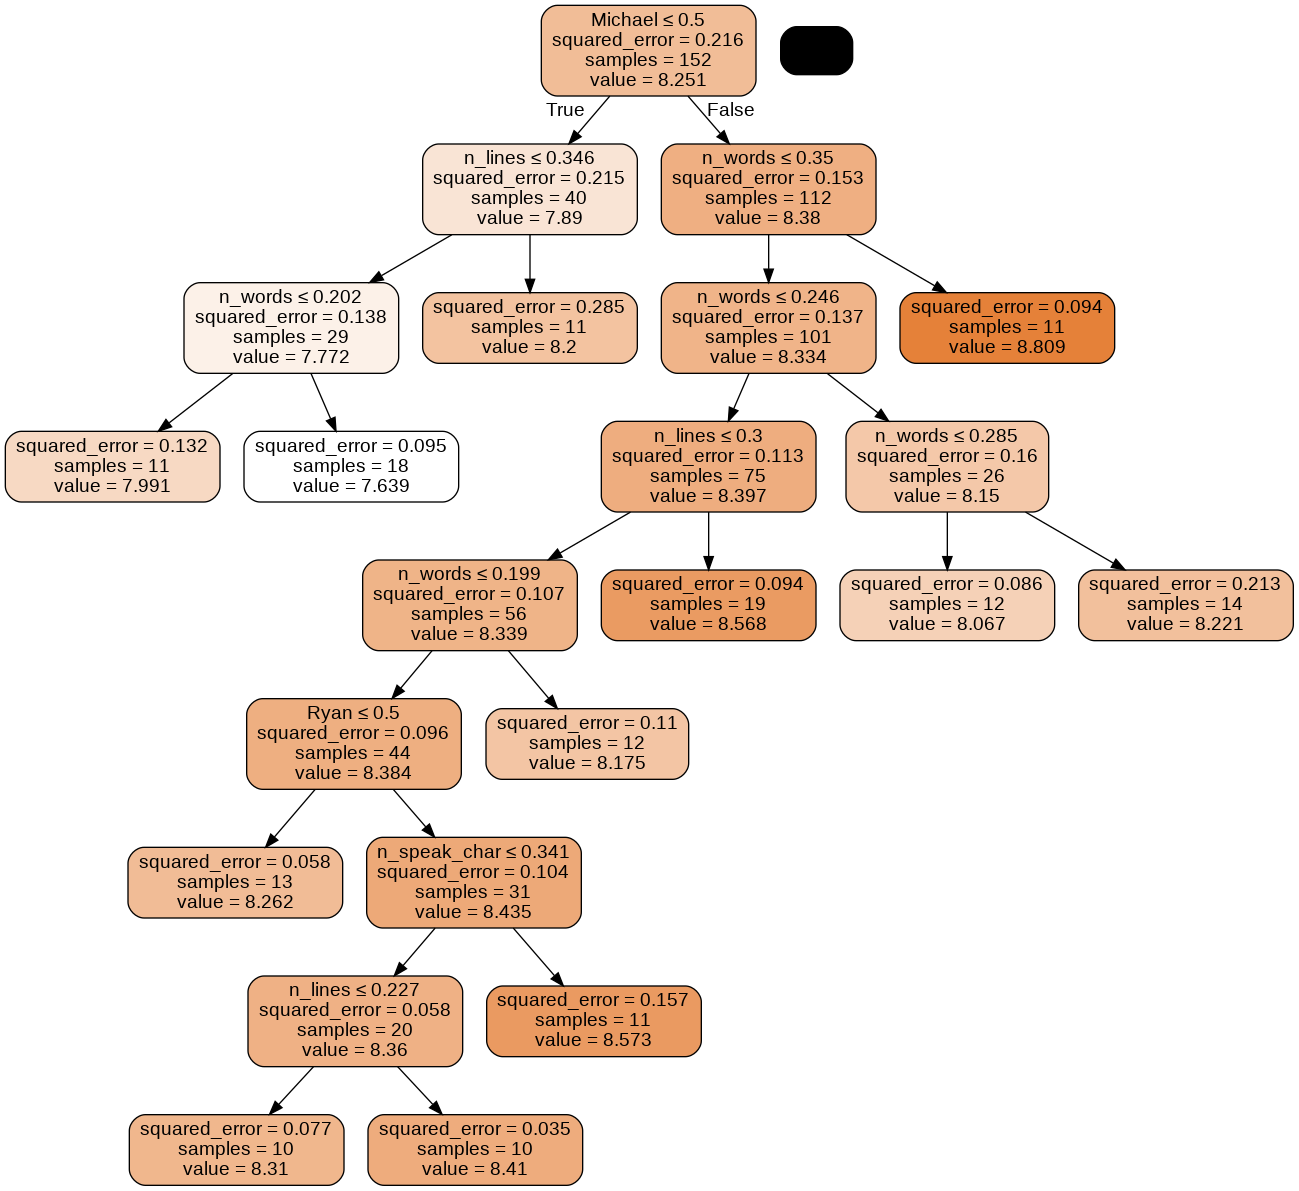

In [ ]:
# create a file to store the figure in
dot_data = StringIO()


export_graphviz(regressor_tuned_pipeline['DTR'], out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True, feature_names = X.columns)


#Add title
print(("\t\t\tFigure 5: Visualization of Regression Tree"))

# import and display the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The above tree indicates which features of previous episodes of The Office are likely to lead to highly rated reunion episodes and which features are likely to lead to a poorer rated reunion episode.

Arrows pointing to the left mean that the first statement in a node is true while arrows pointing to the right indicate the statement is false. The final line in each node ("value"), states the expected IMDb rating from that combination of features. Finally, the nodes with "squared_error" state how much our predictions deviate from our expected target value, and so we prefer and trust nodes with a smaller squared error term.

*Note: The darker the colour of a leaf, the higher the predicted rating of an episode that includes features from the previous leaves. Furthermore, we must take into account here that as we scaled the number of lines and number of words per episode and so must convert these scaled values back to their original values when making analysing results and making recommendations.*

### <ins>Results</ins>

As depicted in *Figure 5*, the regression tree predicts that the highest rated reunion episode is possible if NBC Univeral includes Michael and a script with at least 2,841 words. In doing so, the model predicts that creators could expect an IMDb rating of 8.8 with a minimal squared error. 

As Michael's inclusion in an episode is the top node, it is evident that Michael is the most important feature in determining whether an episode will be rated highly or not. 

Furthermore, if we look at the node for Ryan's appearance in an episode, we see that the model predicts that an episode will be higher if Ryan is in an episode, than if he is not. Therefore, it would seem wise to also suggest to the creators to include this character in the reunion episode. 

In contrast, if we look elsewhere on the tree, we observe that the model anticipates that if Michael is not in the show and the number of lines is fewer than 301 but the number of words is more than 2,104, then the creators should expect a poorly rated episode with an IMDb rating of just 7.639 (again with a very low error). 

If we look at the features that make up the highest and lowest rated episodes predicted by the model, another conclusion we could draw from the regression tree is that, while critics prefered more dialogue in an episode (as they prefered episodes with a higher number of words), they disliked characters having longer lines, and instead would prefer episodes with a higher number of shorter lines. 


In [ ]:
importancefeat_importance = regressor_tuned_pipeline['DTR'].tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(X.columns, regressor_tuned_pipeline['DTR'].feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
Michael,0.479678
n_words,0.327341
n_lines,0.152488
n_speak_char,0.021737
Ryan,0.018757


From the above table, we further understand which features NBC Universal should pay closest attention to when deciding on the format for their reunion episode. As indicated above, these are: ```Michael```, ```n_words```, ```n_lines```, ```n_speak_char```, and ```Ryan``` as these 5 features clearly have the highest feature importance. 

Examining the relationship between four of these features and IMDb rating, we see the following:

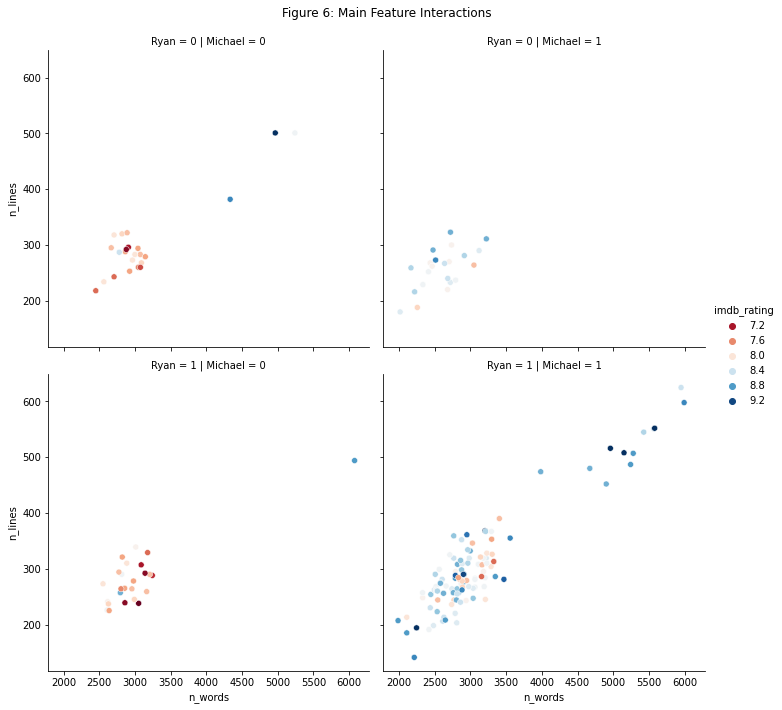

In [ ]:
# Plotting the important features on a scatter plot to show the differences in IMDb rating.
figure = sns.relplot(
    data=d_regression,
    x="n_words", y="n_lines", hue='imdb_rating',  col="Michael", row='Ryan', palette =  'RdBu',
)
figure.fig.subplots_adjust(top=.92)
figure.fig.suptitle('Figure 6: Main Feature Interactions')
plt.show()

*Figure 6* above depicts how previous episodes of The Office have performed based on ```Michael```, ```n_words```, ```n_lines```, and ```Ryan```. In the top right plot, we see that when neither Michael nor Ryan are in the episode, the majority of the episodes are rated poorly. When Michael is in the episode without Ryan, we see that the scripts appear to be shorter with most of the episodes having around 2,500 words and 275 lines. Episodes of this nature appear to be rated relatively high, however few, if any, attain an extremely high IMDb score. Similarly when Ryan is in the episode and Michael is not present, IMDb ratings are extremly poor. 

Conversely, when both Ryan and Michael are both present in an episode, we see a large number of good episodes. Episodes with more than 4,000 words and 420 lines have extremely high ratings which average to a score of 8.8. This analysis further supports our recommendations to NBC Universal. 

<br>

#### <ins>Final Conclusions</ins>:
Our model performs relatively well, as predictions drawn from the model support our initial data analysis findings and have relatively low mean squared error scores. Additionally, the overall R<sup>2</sup> score for our model is close to 1, indicating that a large proportion of our testing data fit the regression tree model implemented. This model also provides NBC Universal with a quick and comprehendible decision tool to aid in their decision of what factors to include in a reunion episode if their goal is to obtain the highest IMDb rated episode possible. 

<br>


**From our analysis, we highly recommend that NBC Universal:**
1. Include Michael and Ryan in the reunion epsiode. 
2. Ensure that the script contains at least 2,841 words and 301 lines
3. Additionally, we would like to acknowledge that, although Dwight and Jim did not appear as features in the model, their consistent presence in the show suggests that they should also be in the reunion episode. 

Furthermore, as we have found that director, writers, guest stars, duration, number of directions, and the number of speaking characters for an episode have smaller impacts on an episode's rating, we instead suggest that the creators use a more qualatitive method to deduce these elements of the reunion episode. 








<br>

## References 

> www.geeksforgeeks.org. (n.d.). ML | Underfitting and Overfitting - GeeksforGeeks. [online] Available at: https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/amp/ [Accessed 12 Mar. 2022].

> Prabhavalkar, N. (2020). The Office Dataset. [online] kaggle.com. Available at: https://www.kaggle.com/nehaprabhavalkar/the-office-dataset [Accessed 4 Mar. 2022].

> Merriam-Webster (2022). Merriam-Webster Dictionary. [online] Merriam-webster.com. Available at: https://www.merriam-webster.com/dictionary/pile%20on [Accessed 10 Mar. 2022].
‌